(4980, 19, 9)
Train Score: 5.75 RMSE
Test Score: 5.64 RMSE
1


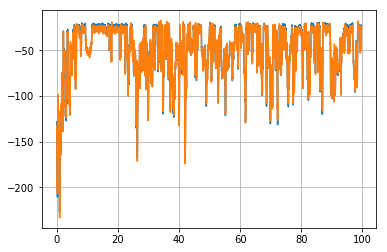

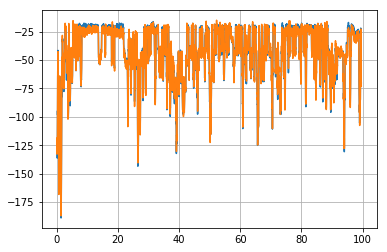

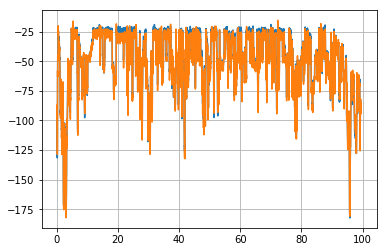

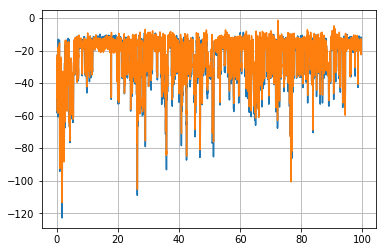

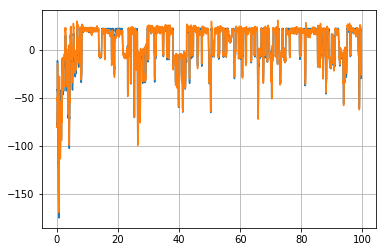

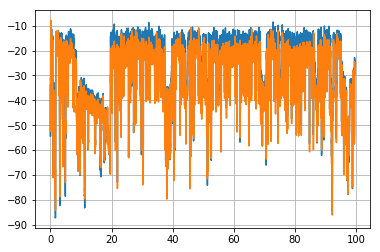

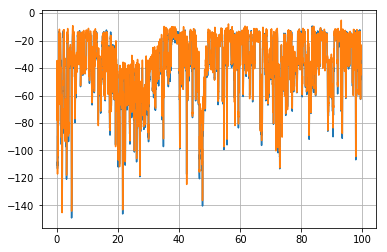

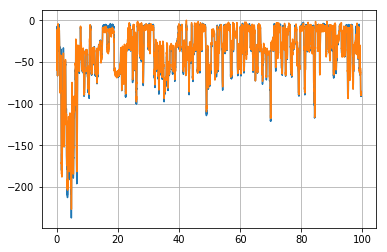

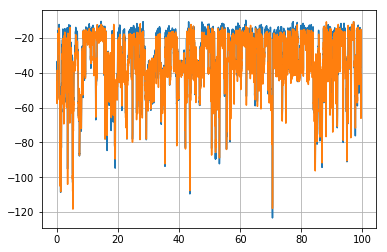

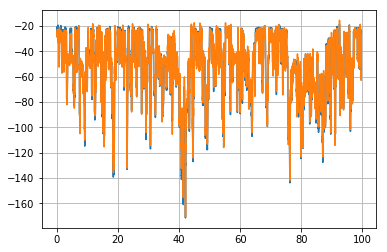

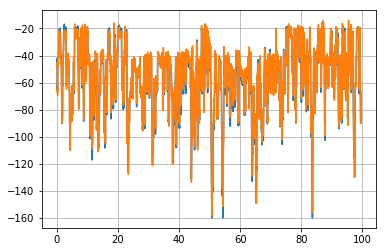

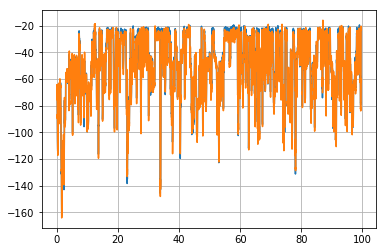

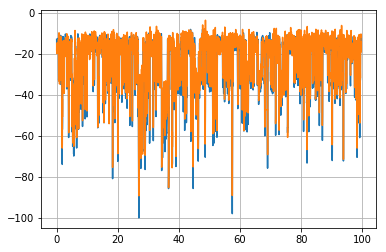

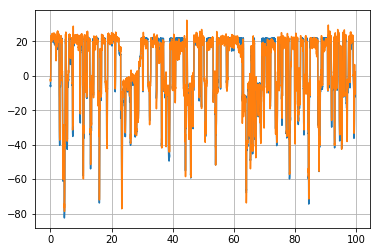

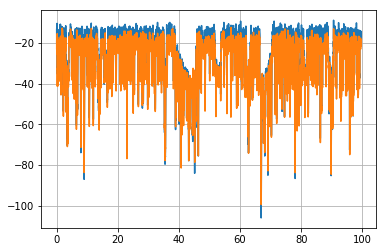

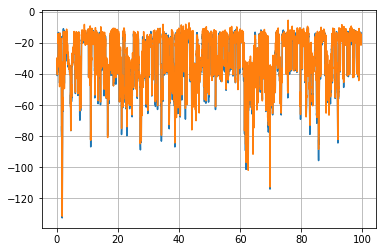

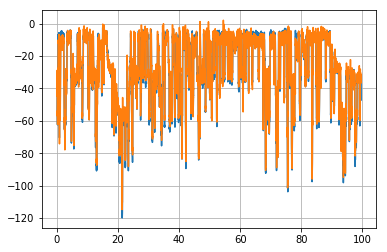

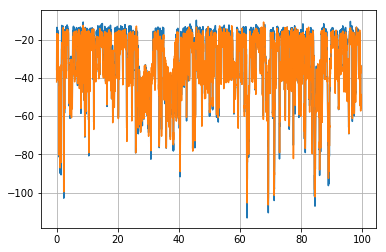

In [3]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy import signal
from scipy.signal import decimate


import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import numpy as np
def analyze_data(index):
		
	def create_dataset(dataset, look_back=1):
		dataX, dataY = [], []
		for i in range(len(dataset)-look_back-1):
			a = dataset[i:(i+look_back), :]
			dataX.append(a)
			dataY.append(dataset[i + look_back, :])
		return numpy.array(dataX), numpy.array(dataY)


	from scipy.io import loadmat
	index_string=str(index)
	stringtoload="SNR140ghzdatafinalLSTM20ms"+index_string+".mat"
	x = loadmat(stringtoload)

	SNR=x['SNR']



	srate=1
	sampledvec=[]

	x=SNR

	x=numpy.array(x)

	dataset=x.T

	scaler = MinMaxScaler(feature_range=(0, 1))
	dataset = scaler.fit_transform(dataset)

	train_size=5000
	test_size = len(dataset) - train_size
	train, test = dataset[0:train_size:], dataset[train_size:len(dataset),:]

	look_back = 19
	trainX, trainY = create_dataset(train, look_back)
	testX, testY = create_dataset(test, look_back)

	
	trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 9))
    
	testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 9))
	print(trainX.shape)

	batch_size=20

	model = Sequential()

	model.add(LSTM(40, batch_input_shape=(batch_size, look_back, 9), stateful=True,return_sequences=True))
	model.add(LSTM(40, batch_input_shape=(batch_size, look_back, 9), stateful=True))
	model.add(Dense(9))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(50):
		model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()

	trainPredict = model.predict(trainX, batch_size=batch_size)
	model.reset_states()
	testPredict = model.predict(testX, batch_size=batch_size)
	trainPredict = scaler.inverse_transform(trainPredict)
	trainY = scaler.inverse_transform(trainY)
	testPredict = scaler.inverse_transform(testPredict)
	testY = scaler.inverse_transform(testY)
	trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
	print('Train Score: %.2f RMSE' % (trainScore))
	testScore = math.sqrt(mean_squared_error(testY, testPredict))
	print('Test Score: %.2f RMSE' % (testScore))
#train prediction plots
	for j in range(9):
		plt.figure()
		plt.grid()
		plt.plot(np.arange(trainY.shape[0])*20/1000,trainY[:,j])
		plt.plot(np.arange(trainY.shape[0])*20/1000,trainPredict[:,j])
#test prediction plots        
	for j in range(9):
		plt.figure()
		plt.grid()
		plt.plot(np.arange(testY.shape[0])*20/1000,testY[:,j])
		plt.plot(np.arange(testY.shape[0])*20/1000,testPredict[:,j])    
    
	return trainY,trainPredict,testY,testPredict,trainScore,testScore

trainscorearray=[]
testscorearray=[]

for a in range(1):
    trainY,trainPredict,testY,testPredict,trainScore,testScore=analyze_data(a+1)
    print(a+1)
    trainscorearray.append(trainScore)
    testscorearray.append(testScore)
import scipy.io as sio
sio.savemat('TrainRMSE140GHzfinal.mat', {'trainScore':trainscorearray})
sio.savemat('TestRMSE11140GHzfinal.mat', {'testScore':testscorearray})
sio.savemat('Traindatasfinal.mat', {'trainPredict':trainPredict})
sio.savemat('Testdatasfinal.mat', {'testPredict':testPredict})

